import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pylab as plt
from keras.preprocessing import image
from tensorflow.keras import utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
import shutil
import splitfolders
import time
from scipy.interpolate import interp1d

In [2]:
# !unzip /home/jovyan/dataset2/221.zip -d /home/jovyan/dataset2/

# !rm -r /home/jovyan/dataset2/dataset2

print(tf.__version__)

2.12.0


functions

In [2]:
SAVED_MODEL_BEST_ACCURACY_RESULTS = []
SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS = []
SAVED_MODEL_BEST_ACCURACY_RESULTS2 = []
SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS2 = []
IMAGE_SIZE = (180,50)
EPOCHS = 300 # try different # 170 for dataset1

In [3]:
def get_image_and_transform(path):
    """ Function for downloading image and transformation
    
    Parameters:
    path (str): path to image location
    
    Returns:
    data (list): image data
    """
    data = utils.load_img(path, color_mode='rgb', target_size=IMAGE_SIZE)
    data = utils.img_to_array(data)
    data = np.expand_dims(data, axis=0)
    data = data / 255.0
    return data

In [4]:
def build_dataset(dataset_dir): # build 2 datasets for training and testing
    x_train, y_train = [], []
    classes = sorted(os.listdir(dataset_dir))
    for i in range(len(classes)):
        class_dir = os.path.join(dataset_dir, classes[i])
        images = os.listdir(class_dir)
        for image in images:
            full_image_path = os.path.join(class_dir, image)
            if 'ipynb_checkpoints' in full_image_path:
                continue
            x_train.append(get_image_and_transform(full_image_path))
            y_train.append(i)
    return x_train, y_train

In [5]:
def get_examples_and_classes(dataset_dir, num): # return persons' names and persons' ears
    classes = sorted(os.listdir(dataset_dir))
    classes.remove('.ipynb_checkpoints') if '.ipynb_checkpoints' in classes else None
    classes.remove('Thumbs.db') if 'Thumbs.db' in classes else None
    examples = []
    for i in range(1, len(classes)):
        class_dir = os.path.join(dataset_dir, classes[i])
        images = os.listdir(class_dir)
        images.remove('.ipynb_checkpoints') if '.ipynb_checkpoints' in images else None
        examples.append(os.path.join(class_dir, images[num]))

    return classes, examples

In [4]:
def plot(accuracy, loss, val_accuracy, val_loss):
    """ Function for returning schedule of accuracy and loss
    
    Parameters:
    accuracy (list): result of training
    loss (list): result of training
    val_accuracy (list): result of training
    val_loss (list): result of training
    
    Returns:
    None: -
    """
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('total loss')
    ax1.plot(loss, color='tab:red', label='Training Loss')
    ax1.plot(val_loss, color='tab:brown', label='Validation Loss')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel('accuracy')
    ax2.plot(accuracy, color='tab:blue', label='Training Accuracy')
    ax2.plot(val_accuracy, color='tab:green', label='Validation Accuracy')
    ax2.tick_params(axis='y')

    # Combine the legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2
    ax1.legend(lines, labels, loc='lower right')

    # Set the title
    plt.title('Графік залежностей точності та втрат від кількості Епох')

    fig.tight_layout()
    plt.show()


In [46]:
def plot_smooth(accuracy, loss, val_accuracy, val_loss):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Total Loss')

    # Smooth the loss and validation loss curves using cubic interpolation
    x = np.arange(len(loss))
    x_smooth = np.linspace(0, len(loss) - 1, 200)
    f_loss = interp1d(x, loss, kind='cubic')
    f_val_loss = interp1d(x, val_loss, kind='cubic')
    loss_smooth = f_loss(x_smooth)
    val_loss_smooth = f_val_loss(x_smooth)

    ax1.plot(x_smooth, loss_smooth, color='tab:red', label='Training Loss')
    ax1.plot(x_smooth, val_loss_smooth, color='tab:brown', label='Validation Loss')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy')

    # Smooth the accuracy and validation accuracy curves using cubic interpolation
    f_accuracy = interp1d(x, accuracy, kind='cubic')
    f_val_accuracy = interp1d(x, val_accuracy, kind='cubic')
    accuracy_smooth = f_accuracy(x_smooth)
    val_accuracy_smooth = f_val_accuracy(x_smooth)

    ax2.plot(x_smooth, accuracy_smooth, color='tab:blue', label='Training Accuracy')
    ax2.plot(x_smooth, val_accuracy_smooth, color='tab:green', label='Validation Accuracy')
    ax2.tick_params(axis='y')

    # Combine the legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2
    ax1.legend(lines, labels, loc='lower right')

    # Set the title
    plt.title('Графік залежностей точності та втрат від кількості Епох(менша к-ть даних)')

    fig.tight_layout()
    plt.show()

In [8]:
def plot_many(title='title', data=[]): # return schedules of accuracy
    for i,o in enumerate(data):
        plt.figure(i)
        plt.plot([i for i in range(EPOCHS)],o, label=title)
        plt.legend(loc='upper left')

In [9]:
def save_lists(): # save lists of accuracy and loss
    t = time.ctime(time.time())[:-5]
    with open(f'accuracy {t}.txt', 'w') as f:
        for item in SAVED_MODEL_BEST_ACCURACY_RESULTS:
            f.write("%s\n" % item)
    with open(f'val_accuracy {t}.txt', 'w') as f:
        for item in SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS:
            f.write("%s\n" % item)

In [10]:
def read_list_from_file(filename): # read accuracy or loss data  from files
    lst = []
    with open(filename, 'r') as file:
        for line in file.readlines():
            if line in ('', ' ','\n'):
                break
            line = line[1:-2].split(', ')
            lst.append([float(i.strip()) for i in line])
    return lst
# file = 'accuracy Sat May  6 11:19:23.txt'
# l = read_list_from_file(file)
# print("sorted list of max  epochs' values for accuracy  ", show_best_res(l))

In [5]:
def show_best_res(list_of_data): # return max value in every list of accuracy
    max_val = {}
    for i, o in enumerate(list_of_data):
        max_val[i] = max(o)
    return dict(sorted(max_val.items(), key=lambda item: item[1], reverse=True))

In [12]:
def create_new_dataset(path):
    images = sorted(os.listdir(path))
    for image in images:
        if 'ipynb_checkpoints' in image:
            continue
        old_path = path + '/' + image
        new_path = f"/home/jovyan/dataset2/dataset2/{image[:3]}"

        if os.path.exists(new_path):
            shutil.copyfile(old_path, new_path+'/'+image)
        else:
            os.mkdir(new_path)
            shutil.copyfile(old_path, new_path+'/'+image)

dataset

In [13]:
train_folder = "/home/jovyan/dataset1/dataset2/train"
test_folder = "/home/jovyan/dataset1/dataset2/test"

In [14]:
image = "/home/jovyan/dataset1/dataset2/test/001.ALI_HD/001 (14).jpg"
image = utils.load_img(image)
image.size

(74, 122)

In [6]:
# data_folder = "/home/jovyan/work/ear/raw"
# create_new_dataset(data_folder)
# train_datagen = "/home/jovyan/dataset2/dataset2"
# splitfolders.ratio(train_datagen, output="/home/jovyan/dataset2/dirty_set", seed=1337, ratio=(.7, 0.3)) 
train_folder = "/home/jovyan/dataset2/train"
test_folder = "/home/jovyan/dataset2/test"

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size = IMAGE_SIZE,
                                            batch_size = 8,
                                            class_mode = 'categorical')


Found 561 images belonging to 222 classes.
Found 237 images belonging to 222 classes.


model

In [8]:
def model(in_1=32, in_2=32, in_3=32, in_4=64):
    """ Function for creating convolutional neural network model
    
    Parameters:
    in_1 (int): filters amount
    in_2 (int): filters amount
    in_3 (int): filters amount
    in_4 (int): filters amount
    
    Returns:
    model (sequential): neural network model
    """
    model = Sequential()
    model.add(Conv2D(filters=in_1,kernel_size=3, strides=1, input_shape=(180,50,3), padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=in_2,kernel_size=3, strides=1, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=in_3,kernel_size=3, strides=1, padding ='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())
    
    
    model.add(Conv2D(filters=in_4,kernel_size=3, strides=1, padding ='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    #model.add(Dense(units = 512 , activation = 'tanh')) # try delete
    model.add(Dense(units = 222 , activation = 'softmax'))

    model.compile( optimizer='Adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

    return model
summary_example = model()
summary_example.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 50, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 25, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 90, 25, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 25, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 12, 32)       0         
 2D)                                                             
                                                      

choose best hyperparameters

In [9]:
def model_and_best_hyperparameters(nums):
    """ Function for training model
    
    Parameters:
    nums (list): list of filters' amount numbers
    
    Returns:
    execution time (int): how long the function took to execute
    """
    start_time1 = time.time() 
    for i in nums:
        start_time2 = time.time()
        
        ready_model = model(i,i,i,i)        # change order 
        trained_model = ready_model.fit(training_set, steps_per_epoch = 32, epochs = EPOCHS,
                                        validation_data = test_set, validation_steps=16)
        
        print("for one training time taken: {:.2f} seconds".format(time.time() - start_time2)) # how much time one training take

        SAVED_MODEL_BEST_ACCURACY_RESULTS.append(trained_model.history['accuracy'])
        SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS.append(trained_model.history['val_accuracy'])
        
    return time.time() - start_time1 # how much time all training take

In [19]:
# all_time = model_and_best_hyperparameters([32])

In [20]:
print("sorted list of max  epochs' values for accuracy  ", show_best_res(SAVED_MODEL_BEST_ACCURACY_RESULTS))
print("sorted list of max  epochs' values for val_accuracy  ", show_best_res(SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS))
# print('all training take {:.2f} minutes'.format(all_time/60))
# save_lists()  

sorted list of max  epochs' values for accuracy   {}
sorted list of max  epochs' values for val_accuracy   {}


train and save model

In [10]:
def final_model():
    ready_model = model()
    call_back = ModelCheckpoint(f"/home/jovyan/weights.hdf5", monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
    trained_model = ready_model.fit(training_set, steps_per_epoch = 16 , epochs = EPOCHS, #len(training_set)
                                    validation_data = test_set, validation_steps=8 , callbacks = [call_back]) #len(test_set)
    
    SAVED_MODEL_BEST_ACCURACY_RESULTS2.append(trained_model.history['accuracy'])
    SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS2.append(trained_model.history['val_accuracy'])
    return trained_model, ready_model


In [ ]:
history, trained_model = final_model()

plot model

In [23]:
# plot_many('accuracy', SAVED_MODEL_BEST_ACCURACY_RESULTS)

sorted list of max  epochs' values for accuracy   {0: 0.91015625}
sorted list of max  epochs' values for val_accuracy   {0: 0.921875}


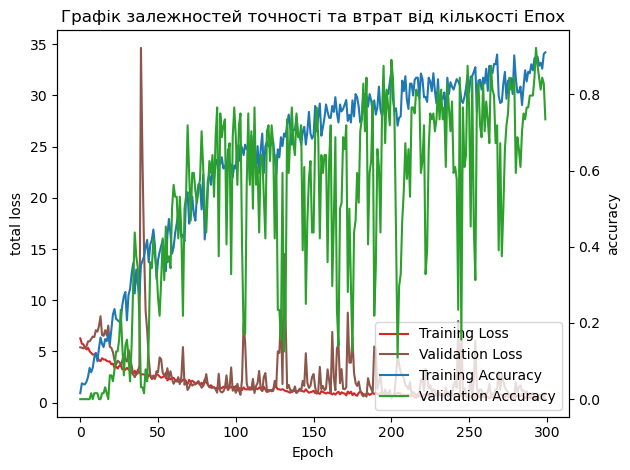

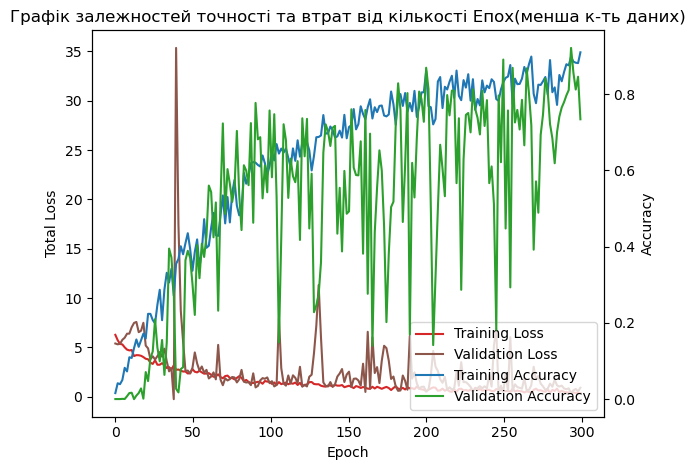

In [47]:
if trained_model:
    print("sorted list of max  epochs' values for accuracy  ", show_best_res(SAVED_MODEL_BEST_ACCURACY_RESULTS2))
    print("sorted list of max  epochs' values for val_accuracy  ", show_best_res(SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS2))
    plot(history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss'])
    plot_smooth(history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss'])
    # save_lists() #val accuracy 0.828125

predict

In [6]:
def contrastive_loss(y, preds, margin=0.01):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)
	# calculate the contrastive loss between the true labels and the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
	# return the computed contrastive loss to the calling function
	return loss

In [9]:
predict_model = Sequential()
ready_model2 = model()
for layer in ready_model2.layers[:-1]:
    predict_model.add(layer)
predict_model.add(Dense(units=1, activation=None))
predict_model.compile(optimizer='adam', loss='contrastive_loss', metrics=['accuracy'])
predict_model.summary()


predict_model.load_weights('weights.hdf5', skip_mismatch=True, by_name=True)

# # Load weights and biases from model manually
# for i in range(len(predict_model.layers) - 1):
#     predict_model.layers[i].set_weights(model.layers[i].get_weights())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 180, 50, 32)       896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 25, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 90, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 25, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 12, 32)       0         
 2D)                                                             
                                                      

In [38]:
def distance_metric(x1, x2):
    return tf.sqrt(tf.reduce_sum(tf.square(x1 - x2), axis=1))

def predict(model, known_data_path, unknown_data_path):
    """ Function for training model
    
    Parameters:
    model (): neural network model
    known_data_path (str): path to image
    unknown_data_path (str): path to image
    
    Returns:
    prediction (bool): identification
    distance (float): how far are examples from each other
    """
    known_data = get_image_and_transform(known_data_path)
    unknown_data = get_image_and_transform(unknown_data_path)

    known_data = model.predict(known_data)
    unknown_data = model.predict(unknown_data)
    distance = distance_metric(unknown_data, known_data)

    threshold = 1.2
    return  bool(distance < threshold), float(distance[0])

predict(predict_model, '/home/jovyan/r1.jpg', '/home/jovyan/12.jpg')

1/1 [==============================] - 0s 15ms/step


(True, 0.4879112243652344)

choose best threshold

In [11]:
def return_lists_of_classes_and_images():
    test_folder = "/home/jovyan/dataset2/train"
    classes, examples1 = get_examples_and_classes(test_folder,0) # every first image
    classes, examples2 = get_examples_and_classes(test_folder, 1) 
    return classes, examples1, examples2

def predict_many(reverse=False):
    classes, examples1, examples2 = return_lists_of_classes_and_images()
    if reverse:
        examples2 = examples2[::-1]
        true_labels = [0 for i in range(len(examples2))]
    else:
        true_labels = [1 for i in range(len(examples2))]
    y_predict_tensors = []
    y_predict_labels = []
    
    for i in range(len(examples1)):  # try build histogram
        predict_label, predict_tensor = predict(predict_model, examples1[i], examples2[i])
        y_predict_tensors.append(predict_tensor) # distance list
        y_predict_labels.append(int(predict_label)) # bool list
    
    return y_predict_tensors, y_predict_labels, true_labels

In [ ]:
y_predict_tensors, y_predict_labels, true_labels = predict_many()

In [ ]:
y_predict_tensors2, y_predict_labels2, true_labels2 = predict_many(True)

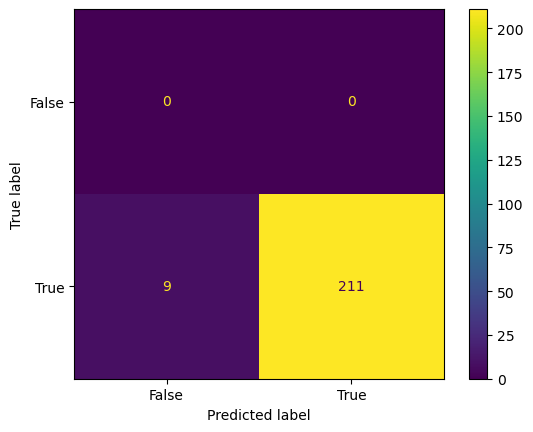

In [13]:
matrix = confusion_matrix(true_labels, y_predict_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

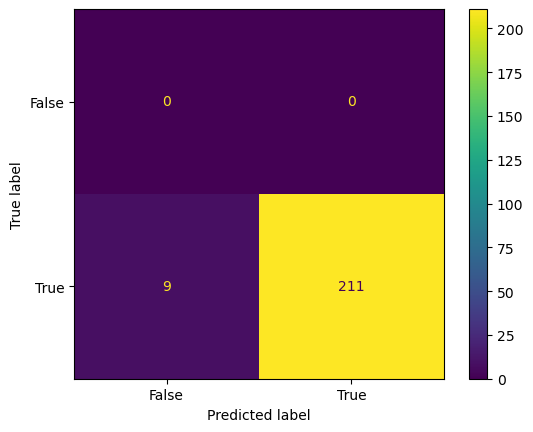

In [15]:
matrix = confusion_matrix(true_labels, y_predict_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [False, True])
cm_display.plot()
plt.show()